<a href="https://colab.research.google.com/github/kannankumar/jupyter-notebooks/blob/hindi-digit-gan/Hindi_Digits_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hindi Digits DCGAN
### Generating images of handwritten Hindi numerals
------

In this notebook I'll be training DCGAN on the [Devanagiri Digits Dataset](http://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset) from the UCI ML repository. With this we'll be able to generate new images of Hindi numerals.

<img src='https://qph.fs.quoracdn.net/main-qimg-188854a1e61d27a5ec6601193621cdb8.webp' width=80% />

The top row represent the printed numerals. We'll be working with the handwritten version of these numerals.  

These are grayscale images of numbers handwritten in the Indian language called Hindi or the Nepali language. Both languages share this script(Devanagiri) and the numerals.

Our goal is to create a DCGAN that can generate new, handwritten images of the Hindi digits.

--------
**Footnote**

This notebook and its code is a fork from [DCGAN notebooks](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/dcgan-svhn) of Udacity Deep Learning Nanodegree course.

The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images;   
you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/DHCD/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%bash
mkdir devanagiri
cp "gdrive/My Drive/DHCD/Train.zip" ./devanagiri/
cp "gdrive/My Drive/DHCD/Test.zip" ./devanagiri/

unzip -q devanagiri/Train.zip
unzip -q devanagiri/Test.zip

rm -rf devanagiri

In [0]:
import fnmatch
import os
import shutil

In [7]:
def count_characters(dir_name):
  dir_path = os.path.join(dir_name)
  print(dir_path, 'Directory Details:')
  counts = {dr: len(os.listdir(os.path.join(dir_path, dr))) for dr in sorted(os.listdir(dir_path))}
  print(counts)

count_characters('Train')  
count_characters('Test')  

Train Directory Details:
{'character_10_yna': 1700, 'character_11_taamatar': 1700, 'character_12_thaa': 1700, 'character_13_daa': 1700, 'character_14_dhaa': 1700, 'character_15_adna': 1700, 'character_16_tabala': 1700, 'character_17_tha': 1700, 'character_18_da': 1700, 'character_19_dha': 1700, 'character_1_ka': 1700, 'character_20_na': 1700, 'character_21_pa': 1700, 'character_22_pha': 1700, 'character_23_ba': 1700, 'character_24_bha': 1700, 'character_25_ma': 1700, 'character_26_yaw': 1700, 'character_27_ra': 1700, 'character_28_la': 1700, 'character_29_waw': 1700, 'character_2_kha': 1700, 'character_30_motosaw': 1700, 'character_31_petchiryakha': 1700, 'character_32_patalosaw': 1700, 'character_33_ha': 1700, 'character_34_chhya': 1700, 'character_35_tra': 1700, 'character_36_gya': 1700, 'character_3_ga': 1700, 'character_4_gha': 1700, 'character_5_kna': 1700, 'character_6_cha': 1700, 'character_7_chha': 1700, 'character_8_ja': 1700, 'character_9_jha': 1700, 'digit_0': 1700, 'digit_1

In [8]:
def move_images(src_dir_name, dst_dir_name):
  src_dir = os.path.join(src_dir_name)
  dst_dir = os.path.join(dst_dir_name)
  print('Copying contents from ', src_dir_name, ' Directory...')

  if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

  # loop through train dir
  for dr in os.listdir(src_dir):
    # match dr with "digit*"
    src_sub_dir = os.path.join(src_dir, dr)
    if os.path.isdir(src_sub_dir) and fnmatch.fnmatch(dr, 'digit*'):
          print(dr)
          
          # copy directory if it matches 'digit*'
          dst_sub_dir = os.path.join(dst_dir, dr)
          shutil.copytree(src=src_sub_dir, dst=dst_sub_dir)
  print('Done!\n\n')
  
move_images('Train', 'train-digits')
move_images('Test', 'test-digits')

digit_7
digit_5
digit_8
digit_9
digit_4
digit_0
digit_2
digit_6
digit_3
digit_1
digit_7
digit_5
digit_8
digit_9
digit_4
digit_0
digit_2
digit_6
digit_3
digit_1


In [0]:
%%bash
rm -rf Train
rm -rf Test

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

## Getting the data

We load in training data, transform it into Tensor datatypes, then create dataloaders to batch our data into a desired size.

In [0]:
import torch
from torchvision import transforms, datasets

transform = transforms.ToTensor()

train_dataset = datasets.ImageFolder(root='train-digits', transform=transform)

batch_size = 128
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

### Visualize the Data

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real, training images that we'll pass to the discriminator. Notice that each image has _one_ associated, numerical label.

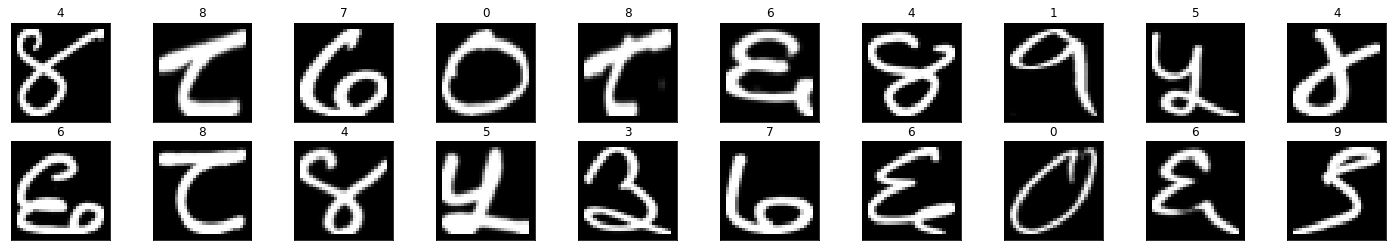

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [4]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [6]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
* The inputs to the discriminator are 32x32x3 tensor images
* You'll want a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later


For the depths of the convolutional layers I suggest starting with 32 filters in the first layer, then double that depth as you add layers (to 64, 128, etc.). Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpooling layers.

You'll also want to use batch normalization with [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) on each layer **except** the first convolutional layer and final, linear output layer. 

#### Helper `conv` function 

In general, each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a convolutional + an optional batch norm layer. We'll create these using PyTorch's [Sequential container](https://pytorch.org/docs/stable/nn.html#sequential), which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 4** and a **stride of 2** for strided convolutions.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [0]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out
    

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.


What's new here is we'll use transpose convolutional layers to create our new images. 
* The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x512. 
* Then, we use batch normalization and a leaky ReLU activation. 
* Next is a series of [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), where you typically halve the depth and double the width and height of the previous layer. 
* And, we'll apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a `tanh` activation.

#### Helper `deconv` function

For each of these layers, the general scheme is transpose convolution > batch norm > ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a transpose convolutional + an optional batch norm layer. We'll create these using PyTorch's Sequential container, which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 4** and a **stride of 2** for transpose convolutions.

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [0]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out
    

## Build complete network

Here we define our models' hyperparameters and instantiate the discriminator and generator from the classes defined above. 

In [11]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. If you can, set this as a variable and move your models to GPU. 
> Later, we'll also move any inputs our models and loss functions see (real_images, z, and ground truth labels) to GPU as well.

In [12]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)    

GPU available for training. Models moved to GPU
Device:  cuda


---
## Discriminator and Generator Losses

Now we need to calculate the losses. And this will be exactly the same as before.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [0]:
def real_loss(D_out, smooth=True):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Not much new here, but notice how I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [0]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [0]:
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [16]:
import pickle as pkl

# training hyperparams
num_epochs = 300

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=100
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    if epoch % 5 == 0:
      # generate and save sample, fake images
      G.eval() # for generating samples

      if train_on_gpu:
          fixed_z = fixed_z.cuda()

      sample_z = G(fixed_z)
      samples.append(vutils.make_grid(sample_z,nrow=10, padding=2, normalize=True))

      G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  300] | d_loss: 1.4757 | g_loss: 0.9155
Epoch [    2/  300] | d_loss: 0.4226 | g_loss: 5.6917
Epoch [    3/  300] | d_loss: 0.3500 | g_loss: 4.3141
Epoch [    4/  300] | d_loss: 0.3673 | g_loss: 3.8738
Epoch [    5/  300] | d_loss: 0.3626 | g_loss: 3.1469
Epoch [    6/  300] | d_loss: 0.3710 | g_loss: 3.5142
Epoch [    7/  300] | d_loss: 0.3801 | g_loss: 2.6704
Epoch [    8/  300] | d_loss: 0.4729 | g_loss: 3.4183
Epoch [    9/  300] | d_loss: 0.6524 | g_loss: 0.5877
Epoch [   10/  300] | d_loss: 0.4789 | g_loss: 3.0149
Epoch [   11/  300] | d_loss: 0.4134 | g_loss: 3.0086
Epoch [   12/  300] | d_loss: 0.4328 | g_loss: 3.2150
Epoch [   13/  300] | d_loss: 0.4922 | g_loss: 1.9003
Epoch [   14/  300] | d_loss: 0.4466 | g_loss: 2.6442
Epoch [   15/  300] | d_loss: 0.5181 | g_loss: 1.4695
Epoch [   16/  300] | d_loss: 0.4525 | g_loss: 2.4794
Epoch [   17/  300] | d_loss: 0.4052 | g_loss: 2.7490
Epoch [   18/  300] | d_loss: 0.4179 | g_loss: 3.6307
Epoch [   19/  300] | d_loss

### Train for 50 epochs

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


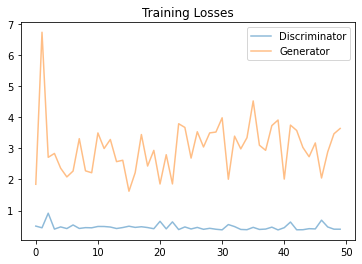

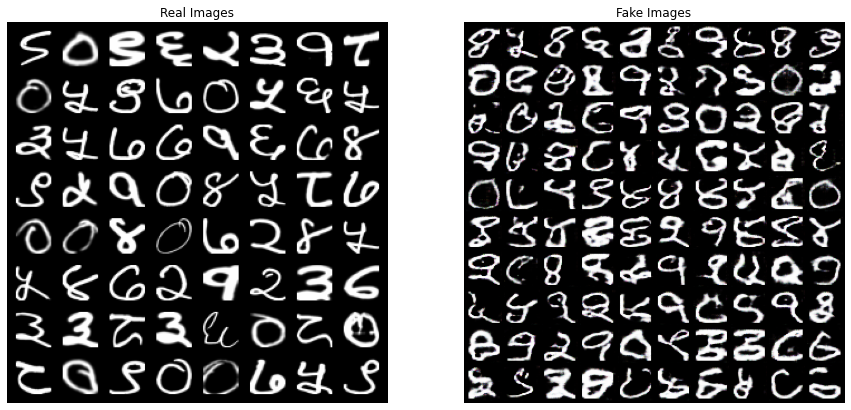

In [46]:
plot_training_performance(losses, device)

### Train for 300 epochs

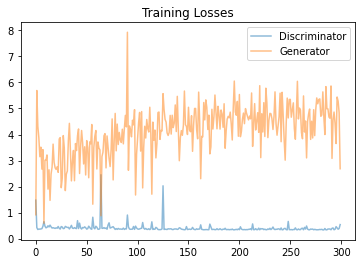

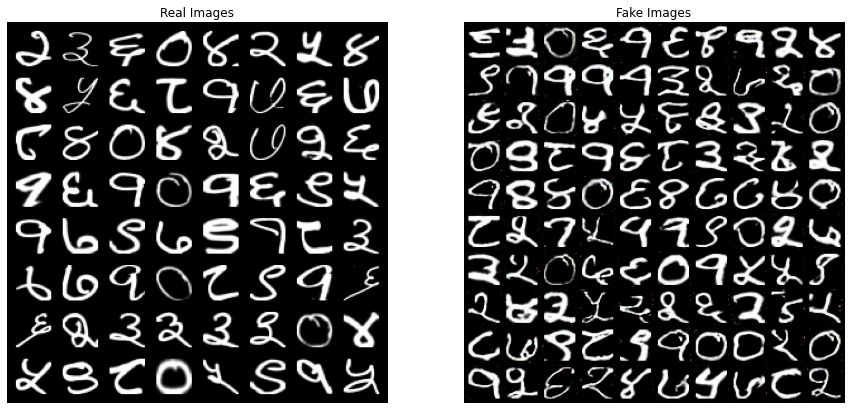

In [21]:
plot_training_performance(losses, device)

### Training Utils 

In [0]:
def plot_training_loss(losses):
  fig, ax = plt.subplots()
  losses = np.array(losses)
  plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
  plt.plot(losses.T[1], label='Generator', alpha=0.5)
  plt.title("Training Losses")
  plt.legend()

In [0]:
def plot_real_and_fake_images(device):
  n_classes = 10
  rows = 10
  sample_size = n_classes*rows
  samples_copy = []

  fixed_noise = torch.randn(sample_size, z_size, device=device)

  if train_on_gpu:
      fixed_noise = fixed_noise.cuda()

  sample_z = G(fixed_noise)
  samples_copy.append(vutils.make_grid(sample_z,nrow=10, padding=2, normalize=True))

  # Grab a batch of real images from the dataloader
  real_batch = next(iter(train_loader))

  # Plot the real images
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

  # Plot the fake images from the last epoch
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(samples[-1].cpu().detach().numpy(),(1,2,0)))
  plt.show()  

In [0]:
def plot_training_performance(losses, device):
  plot_training_loss(losses)
  plot_real_and_fake_images(device)

## Future Work
With this most basic GAN architechture tried, I'm excited to use this dataset to pursue many more interesting paths. I've listed a few from the top of my head:
1. Digit generation
> - Instead of randomly generating a digit, try to generate a particular digit. Eg - Generate digit 4
> - This is very well document using a **Conditional GANs**.
> - The labels present in the dataset can be used to train the Discriminator to classify not just real or fake but also the class label for the generated image.   

2. Try better GAN architechtures

3. Try out some of the GAN hacks to improve the generated images

### Closing Words
With this experiment I learnt the following things:
- **Training GANs are HARD**. However cool and easy it looks in the latest paper about generating faces and horses and zebras, it is really hard. To think, this is the most basic GAN, imagine how much "fun" training newer and complex architechtures will be like.

- Having made the previous point, I find the concept of **GAN as the most beautiful concept** about Deep Learning so far - the symmetry, the equilibrium, the adversarial nature - just beautiful!. Ian Goodfellow,  you Genius!



